# Workflow Scheduling Problem

## Introduction
We consider the following optimization problem (based on the formulation in [[1](#TaskWorkflow)]) : we have $W(t)$ available workers or resources and $N$ jobs that each job $j$ requires $T(j)$ time, and takes $r(j)$ resources to be completed. Given a set of dependencies for each job, where we know which job depends on the completion of others before starting, we need to determine the order of job completion that minimizes the total execution time.
### Assumptions
- a job may occupy only a single time slot at most: $\forall j \,\,\, T(j) = 1$
- given sufficient resources, jobs can be started in the same time slot
- all resources are identical and the amount of available resources at a current time step is given by the number $W(t)$
- jobs can only be started if all parent jobs are completed.

### Possible extensions
- Separate resources into multiple categories with jobs requiring different types
- Jobs that take more than one operation

## Mathematical Modeling

The input of the model is


We define a binary variable for the optimization problem: an $t_{max}\times N$ matrix $x$ such that
$\begin{aligned}
x_{tj} =
\begin{cases}
      1 & \text{job } j \text{ is done on the } t_\text{th} \text{ time slot} \\
      0 & \text{else}
\end{cases}\\
\end{aligned}$

We have 3 constraints:

(1) All jobs must be completed exactly once: $\forall j\in[1,N] \,\,\, \sum_t x_{tj}=1$

(2) All jobs may use no more than the available resources: $\forall t\in[0,t_{max}] \,\,\, \sum_j x_{tj} r_j \leq W_t$

(3) All dependent jobs must have parent jobs completed before starting $x_{t_1j_1} x_{t_2j_2} = 0 \,\,\, \forall j_1, t_1\leq t_2, j_2 \text{ depends on } j_1$


The objective function to minimize is the total cost function:
$$
\min_{x} \sum_{t} x_{tN}\cdot t
$$
which favors schedules that are done early.

### Necessary Packages

In this demo, besides the `classiq` package, we'll use the following packages:

In [1]:
%%capture
! pip install networkx
! pip install pyomo
! pip install pandas
! pip install matplotlib

## Defining the optimization model

In [2]:
from typing import List, Tuple, cast  # noqa

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np  # noqa
import pandas as pd
import pyomo.environ as pyo
from IPython.display import Markdown, display

In [3]:
def define_workflow_problem(
    G, num_timeslots, available_capacities, work_loads
) -> pyo.ConcreteModel:
    model = pyo.ConcreteModel("task_scheduling")

    timeslots = range(num_timeslots)
    assert len(timeslots) == len(available_capacities)
    works = range(len(G.nodes))
    assert len(works) == len(work_loads)

    last_works = [node for node in G.nodes if G.out_degree(node) == 0]
    assert len(last_works) == 1
    last_work = last_works[0]
    # works with no dependancies
    root_works = [node for node in G.nodes if G.in_degree(node) == 0]

    model.x = pyo.Var(timeslots, works, domain=pyo.Binary)

    @model.Constraint(works)
    def all_works_are_done(model, i):  # constraint (1)
        return sum(model.x[t, i] for t in timeslots) == 1

    @model.Constraint(timeslots)
    def capacity_is_valid(model, t):  # constraint(2)
        return (
            sum(model.x[t, i] * work_loads[i] for i in works) <= available_capacities[t]
        )

    @model.Constraint(works, works, timeslots, timeslots)
    def works_done_by_their_order(model, i, j, t1, t2):  # constraint (3)
        if G.has_edge(i, j) and t1 >= t2:
            return model.x[t1, i] * model.x[t2, j] == 0
        return pyo.Constraint.Feasible

    # eliminate all timeslots that are not possible for the task in order to save qubits
    distances_from_ends = nx.floyd_warshall_numpy(G)
    distances_from_roots = nx.floyd_warshall_numpy(G.reverse())

    @model.Constraint(works, timeslots)
    def eliminating_rule(model, i, t):
        end_distance = int(np.min(distances_from_ends[i, last_works]))
        start_distance = int(np.min(distances_from_roots[i, root_works]))
        if (t < start_distance) or (t >= len(timeslots) - end_distance):
            return model.x[t, i] == 0
        return pyo.Constraint.Feasible

    # minimize the end time of the last work
    model.cost = pyo.Objective(
        expr=sum(model.x[t, last_work] * (t + 1) for t in timeslots), sense=pyo.minimize
    )

    return model

### Visualization helper functions

In [4]:
import random


def plot_graph(solution=None, ax=None):
    if solution is not None:
        # determine how many tasks start in each timeslot
        num_tasks = [sum(solution[t]) for t in range(num_timeslots)]
        max_tasks = max(num_tasks)

        pos = {}

        # find all the tasks that start in particular start time
        for start in np.nonzero(solution.sum(axis=1))[0]:
            locations = solution[start].nonzero()[0]
            pos.update(
                {
                    n: (start, i + (max_tasks - num_tasks[start]) / 2)
                    for i, n in enumerate(locations)
                }
            )
    else:
        pos = {
            node: (order, random.random())
            for order, node in enumerate((nx.topological_sort(G)))
        }

    options = {
        "font_size": 12,
        "node_size": 1000,
        "node_color": "white",
        "edgecolors": "black",
        "linewidths": 3,
        "width": 3,
    }
    # G = nx.DiGraph(edges)
    nx.draw_networkx(G, pos, ax=ax, **options)

    # Set margins for the axes so that nodes aren't clipped
    if ax is None:
        ax = plt.subplot()
    ax.margins(0.20)
    if solution is not None:
        ax.set_title("Suggested sequence")
    ax.set_xlabel("Timeslot")


def plot_assignments(solution, ax=None):
    if ax is None:
        ax = plt.subplot()
    ax.pcolormesh(solution.T, edgecolors="w", linewidth=4, cmap="OrRd")
    ax.set_aspect(0.8)
    ax.set_xlabel("Timeslot")
    ax.set_ylabel("Task Number")
    ax.set_title("Task assignment")


def plot_resource_graph(solution=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots()

    x_pos = np.arange(len(capacities))
    if solution is not None:
        ax.set_title("Utilization")
        num_resources = [np.dot(solution[t], workloads) for t in range(num_timeslots)]
        ax.bar(x_pos + 0.1, num_resources, label="used resources", color="r", width=0.5)
    ax.bar(x_pos, capacities, label="available_resources", color="g", width=0.5)
    ax.set_xticks(x_pos)
    ax.legend()
    ax.set_xlabel("Timeslot")
    ax.set_ylabel("Resources")


def plot_workloads(ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_title("Work Loads")
    x_pos = np.arange(len(workloads))
    ax.bar(x_pos, workloads, width=0.5)
    ax.set_xticks(x_pos)
    ax.set_xlabel("Jobs")
    ax.set_ylabel("Required Resources")


def is_printable_solution(solution):
    return np.array_equal(solution.sum(axis=0), np.ones(solution.shape[1]))


def plot_workflow(solution=None):
    if solution is None:
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        plot_resource_graph(ax=axes[0])
        plot_graph(ax=axes[1])
        plot_workloads(ax=axes[2])

    else:
        if is_printable_solution(solution):
            fig, axes = plt.subplots(2, 2, figsize=(12, 10))
            plot_resource_graph(solution, axes[0, 0])
            plot_workloads(axes[0, 1])
            plot_assignments(solution, axes[1, 1])
            plot_graph(solution, axes[1, 0])
        else:
            # illegal solution
            fig, axes = plt.subplots(1, 3, figsize=(18, 5))
            plot_resource_graph(solution, axes[0])
            plot_workloads(axes[1])
            plot_assignments(solution, axes[2])

## Initialize specific problem instance

We create a workflow dependecies graph. For the small instance, all timeslots capacities and work loads are equal to each other.

In [5]:
def small_example():
    G = nx.DiGraph()

    nodes = range(4)
    edges = [(0, 1), (1, 3), (2, 3)]
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)
    num_timeslots = len(G.nodes) - 1
    capacities = 3 * np.ones(num_timeslots)
    workloads = np.ones(len(nodes))

    return (
        define_workflow_problem(
            G, num_timeslots, available_capacities=capacities, work_loads=workloads
        ),
        G,
        num_timeslots,
        capacities,
        workloads,
    )


def large_example():
    G = nx.DiGraph()

    nodes = range(6)
    edges = [(0, 1), (0, 3), (0, 2), (2, 4), (3, 4), (1, 5), (4, 5)]
    workloads = [1, 3, 2, 2, 1, 1]
    capacities = [1, 3, 4, 3, 1]
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)

    num_timeslots = len(capacities)

    return (
        define_workflow_problem(
            G, num_timeslots, available_capacities=capacities, work_loads=workloads
        ),
        G,
        num_timeslots,
        capacities,
        workloads,
    )

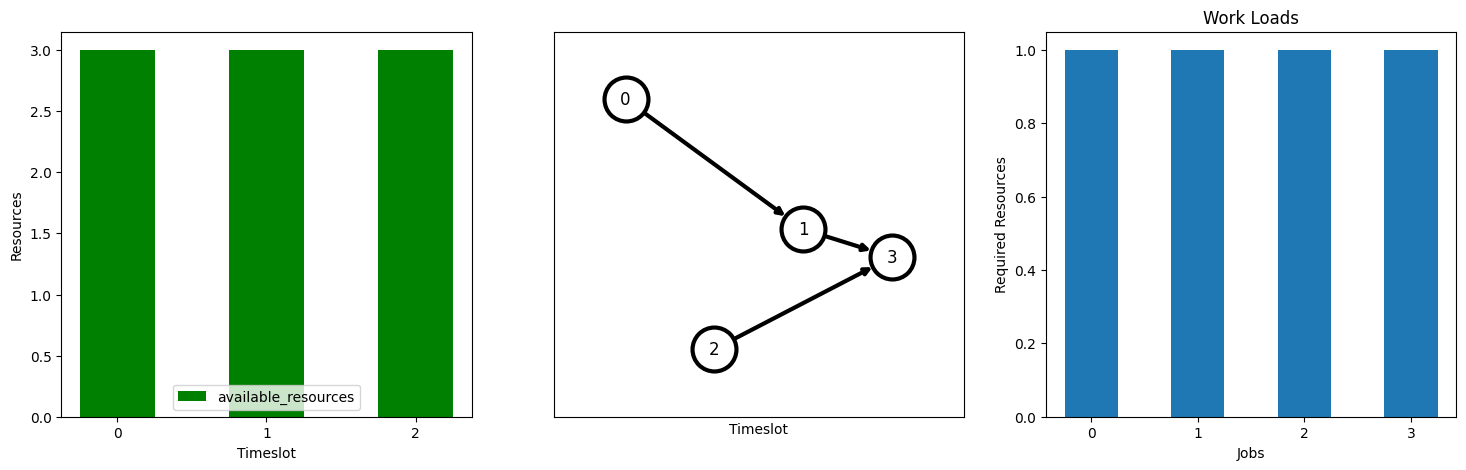

In [6]:
tasks_model, G, num_timeslots, capacities, workloads = small_example()
plot_workflow()

### The resulting Pyomo model

In [7]:
tasks_model.pprint()

13 Set Declarations
    all_works_are_done_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    4 : {0, 1, 2, 3}
    capacity_is_valid_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    3 : {0, 1, 2}
    eliminating_rule_index : Size=1, Index=None, Ordered=True
        Key  : Dimen : Domain                                            : Size : Members
        None :     2 : eliminating_rule_index_0*eliminating_rule_index_1 :   12 : {(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2), (3, 0), (3, 1), (3, 2)}
    eliminating_rule_index_0 : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    4 : {0, 1, 2, 3}
    eliminating_rule_index_1 : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :  

# Solve the optimization model with hybrid classical/quantum QAOA (Quantum Approximate Optimization Algorithm)

## Setting Up the Classiq Problem Instance

In order to solve the Pyomo model defined above, we use the Classiq combinatorial optimization engine. For the quantum part of the QAOA algorithm (`QAOAConfig`) - define the number of repetitions (`num_layers`):

In [8]:
from classiq import construct_combinatorial_optimization_model
from classiq.applications.combinatorial_optimization import OptimizerConfig, QAOAConfig

qaoa_config = QAOAConfig(num_layers=8, penalty_energy=20)

For the classical optimization part of the QAOA algorithm we define the maximum number of classical iterations (`max_iteration`) and the $\alpha$-parameter (`alpha_cvar`) for running CVaR-QAOA, an improved variation of the QAOA algorithm [[3](#cvar)]:

In [9]:
optimizer_config = OptimizerConfig(max_iteration=20.0, alpha_cvar=0.3)

Lastly, we load the model, based on the problem and algorithm parameters, which we can use to solve the problem:

In [10]:
qmod = construct_combinatorial_optimization_model(
    pyo_model=tasks_model,
    qaoa_config=qaoa_config,
    optimizer_config=optimizer_config,
)

We also set the quantum backend we want to execute on:

In [11]:
from classiq import set_execution_preferences
from classiq.execution import ClassiqBackendPreferences, ExecutionPreferences

backend_preferences = ExecutionPreferences(
    backend_preferences=ClassiqBackendPreferences(backend_name="aer_simulator")
)

qmod = set_execution_preferences(qmod, backend_preferences)

In [12]:
with open("task_scheduling_problem.qmod", "w") as f:
    f.write(qmod)

## Synthesizing the QAOA Circuit and Solving the Problem

We can now synthesize and view the QAOA circuit (ansatz) used to solve the optimization problem:

In [13]:
from classiq import show, synthesize

qprog = synthesize(qmod)
show(qprog)

Opening: https://platform.classiq.io/circuit/c8cd117d-28e3-48e5-9540-23e7b1be1dbb?version=0.38.0.dev42%2Bfd36e2c41c


We now solve the problem by calling the `execute` function on the quantum program we have generated:

In [14]:
from classiq import execute

res = execute(qprog).result()

## Analyzing the results

We can check the convergence of the run:

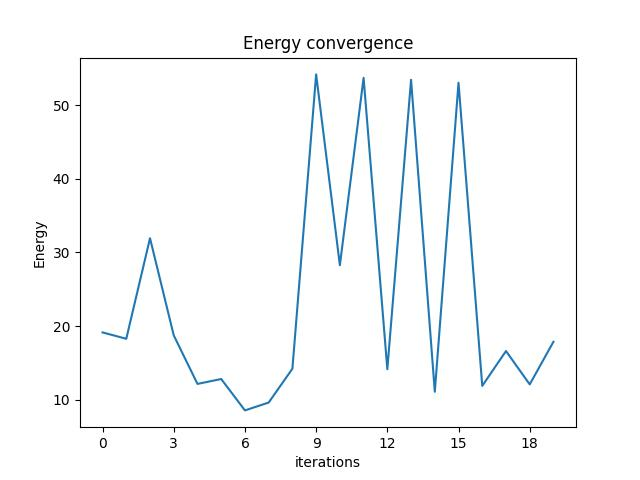

In [15]:
from classiq.execution import VQESolverResult

vqe_result = res[0].value
vqe_result.convergence_graph

And print the optimization results:

In [16]:
import pandas as pd

from classiq.applications.combinatorial_optimization import (
    get_optimization_solution_from_pyo,
)

solution = get_optimization_solution_from_pyo(
    tasks_model, vqe_result=vqe_result, penalty_energy=qaoa_config.penalty_energy
)
optimization_result = pd.DataFrame.from_records(solution)
optimization_result.sort_values(by="cost", ascending=True).head(5)

,probability,cost,solution,count
0,0.069,3.0,"[1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0]",69
3,0.053,3.0,"[1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0]",53
4,0.050,3.0,"[0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]",50
6,0.045,3.0,"[0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0]",45
43,0.008,23.0,"[1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0]",8


In [17]:
idx = optimization_result.cost.idxmin()
print(
    "x =", optimization_result.solution[idx], ", cost =", optimization_result.cost[idx]
)

x = [1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0] , cost = 3.0


And the histogram:

array([[<Axes: title={'center': 'cost'}>]], dtype=object)

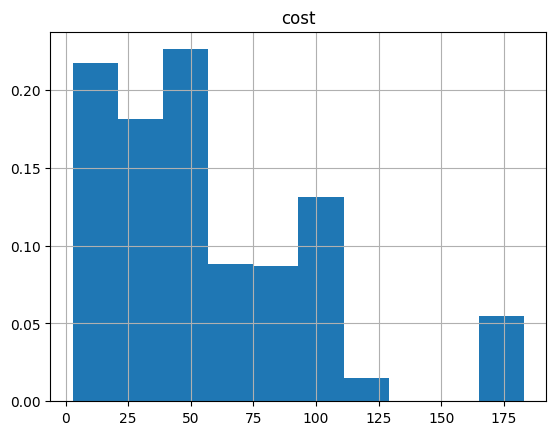

In [18]:
optimization_result.hist("cost", weights=optimization_result["probability"])

### Best solution

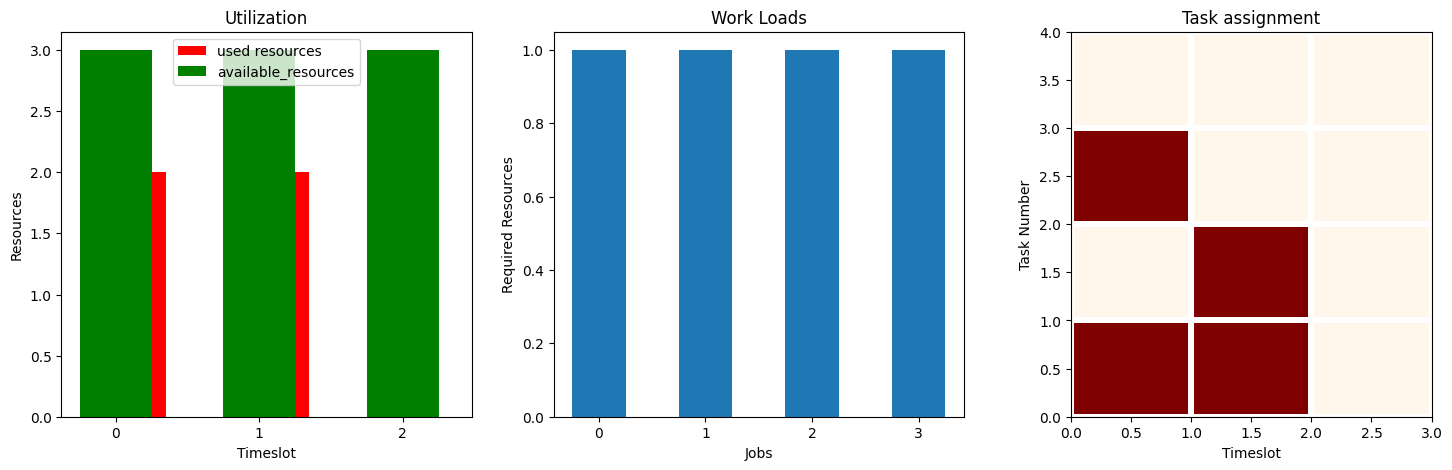

In [19]:
qaoa_solution = np.array(
    optimization_result.solution[optimization_result.cost.idxmin()]
).reshape(num_timeslots, len(G.nodes))
plot_workflow(qaoa_solution)

## Compare to a classical optimizer result

In [20]:
from pyomo.opt import SolverFactory

solver = SolverFactory("couenne")
solver.solve(tasks_model)

tasks_model.display()

Model task_scheduling

  Variables:
    x : Size=12, Index=x_index
        Key    : Lower : Value : Upper : Fixed : Stale : Domain
        (0, 0) :     0 :   1.0 :     1 : False : False : Binary
        (0, 1) :     0 :   0.0 :     1 : False : False : Binary
        (0, 2) :     0 :   1.0 :     1 : False : False : Binary
        (0, 3) :     0 :   0.0 :     1 : False : False : Binary
        (1, 0) :     0 :   0.0 :     1 : False : False : Binary
        (1, 1) :     0 :   1.0 :     1 : False : False : Binary
        (1, 2) :     0 :   0.0 :     1 : False : False : Binary
        (1, 3) :     0 :   0.0 :     1 : False : False : Binary
        (2, 0) :     0 :   0.0 :     1 : False : False : Binary
        (2, 1) :     0 :   0.0 :     1 : False : False : Binary
        (2, 2) :     0 :   0.0 :     1 : False : False : Binary
        (2, 3) :     0 :   1.0 :     1 : False : False : Binary

  Objectives:
    cost : Size=1, Index=None, Active=True
        Key  : Active : Value
        None 

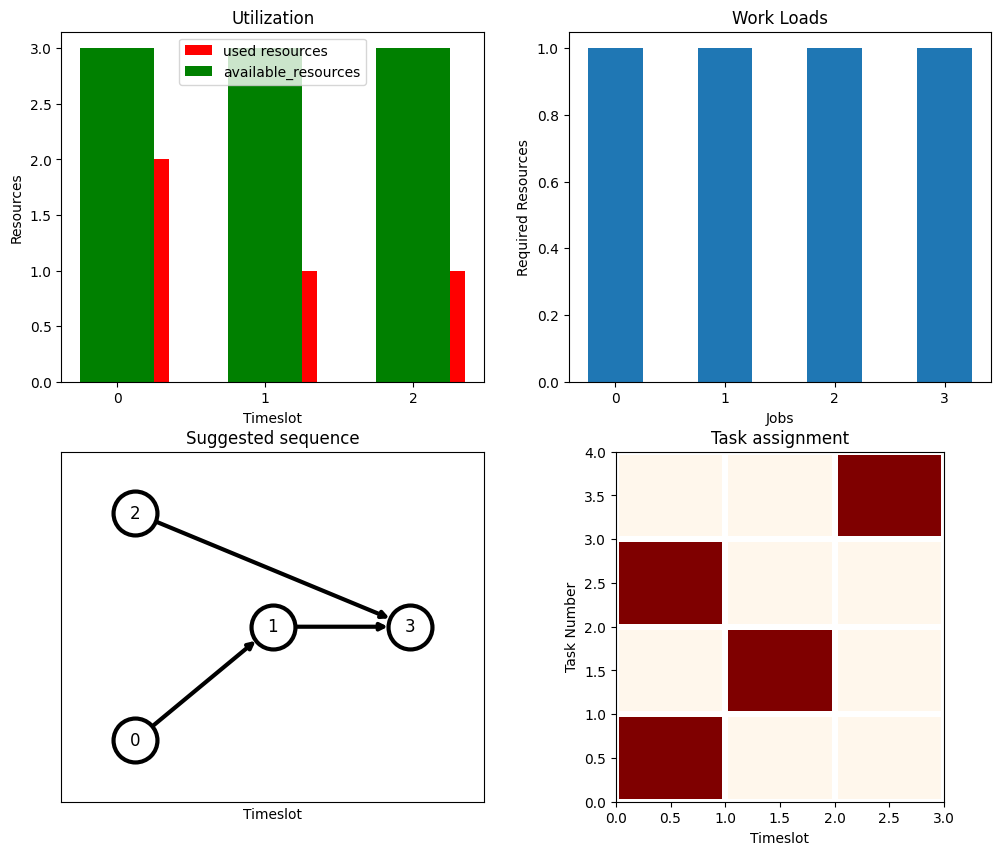

In [21]:
classical_solution = np.array(
    [
        int(pyo.value(tasks_model.x[idx]))
        for idx in np.ndindex(num_timeslots, len(G.nodes))
    ]
).reshape(num_timeslots, len(G.nodes))
plot_workflow(classical_solution)

# Large Example

We will try a more elaborate example, involving more works with non-uniform workloads and resources.

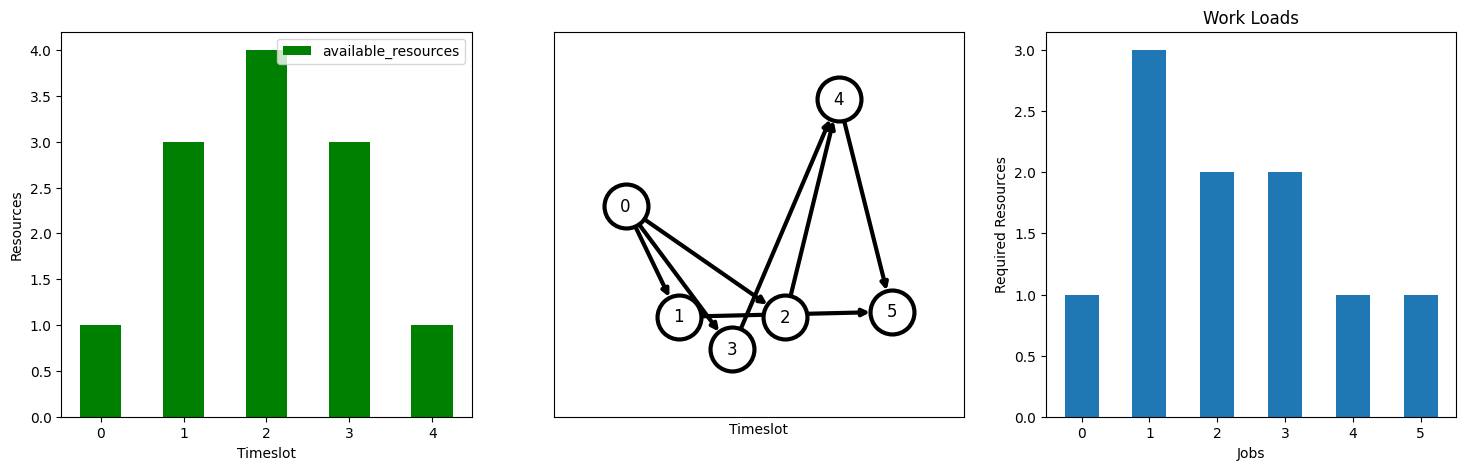

In [22]:
tasks_model_large, G, num_timeslots, capacities, workloads = large_example()
plot_workflow()

In [23]:
tasks_model_large.pprint()

13 Set Declarations
    all_works_are_done_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    6 : {0, 1, 2, 3, 4, 5}
    capacity_is_valid_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    5 : {0, 1, 2, 3, 4}
    eliminating_rule_index : Size=1, Index=None, Ordered=True
        Key  : Dimen : Domain                                            : Size : Members
        None :     2 : eliminating_rule_index_0*eliminating_rule_index_1 :   30 : {(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4)}
    eliminating_rule_index_0 : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    6 : {0, 1,

In [24]:
from classiq import (
    construct_combinatorial_optimization_model,
    execute,
    set_execution_preferences,
    show,
    synthesize,
)
from classiq.applications.combinatorial_optimization import OptimizerConfig, QAOAConfig
from classiq.execution import ExecutionPreferences, IBMBackendPreferences

qaoa_config = QAOAConfig(num_layers=8, penalty_energy=20.0)

optimizer_config = OptimizerConfig(max_iteration=1, alpha_cvar=0.6)

qmod = construct_combinatorial_optimization_model(
    pyo_model=tasks_model_large,
    qaoa_config=qaoa_config,
    optimizer_config=optimizer_config,
)

backend_preferences = ExecutionPreferences(
    backend_preferences=ClassiqBackendPreferences(backend_name="aer_simulator")
)

qmod = set_execution_preferences(qmod, backend_preferences)

In [25]:
with open("task_scheduling_problem_large.qmod", "w") as f:
    f.write(qmod)

In [26]:
qprog = synthesize(qmod)
show(qprog)

Opening: https://platform.classiq.io/circuit/e0acf6f7-52c2-4f08-93b3-b72e095f257a?version=0.38.0.dev42%2Bfd36e2c41c


In [27]:
res = execute(qprog).result()

As the search space here is much larger and involving many qubits, the optimizer takes much more time and might not converge to a legal solution

And print the optimization results:

In [28]:
import pandas as pd

from classiq.applications.combinatorial_optimization import (
    get_optimization_solution_from_pyo,
)

solution = get_optimization_solution_from_pyo(
    tasks_model_large,
    vqe_result=res[0].value,
    penalty_energy=qaoa_config.penalty_energy,
)
optimization_result = pd.DataFrame.from_records(solution)
optimization_result.sort_values(by="cost", ascending=True).head(5)

,probability,cost,solution,count
924,0.001,84.0,"[1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, ...",1
206,0.001,105.0,"[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, ...",1
563,0.001,120.0,"[1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, ...",1
368,0.001,120.0,"[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",1
625,0.001,125.0,"[1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, ...",1


In [29]:
idx = optimization_result.cost.idxmin()
print(
    "x =", optimization_result.solution[idx], ", cost =", optimization_result.cost[idx]
)

x = [1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0] , cost = 83.99999999999983


And the histogram:

array([[<Axes: title={'center': 'cost'}>]], dtype=object)

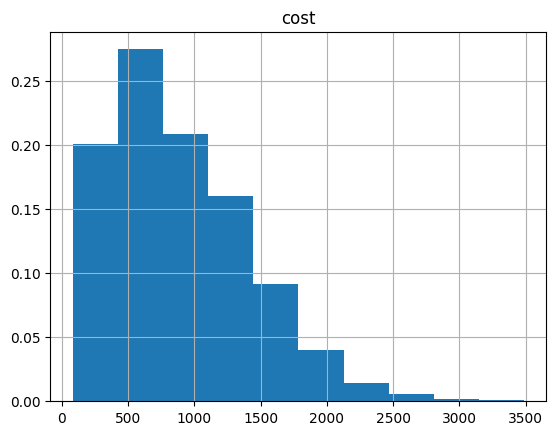

In [30]:
optimization_result.hist("cost", weights=optimization_result["probability"])

### Best solution

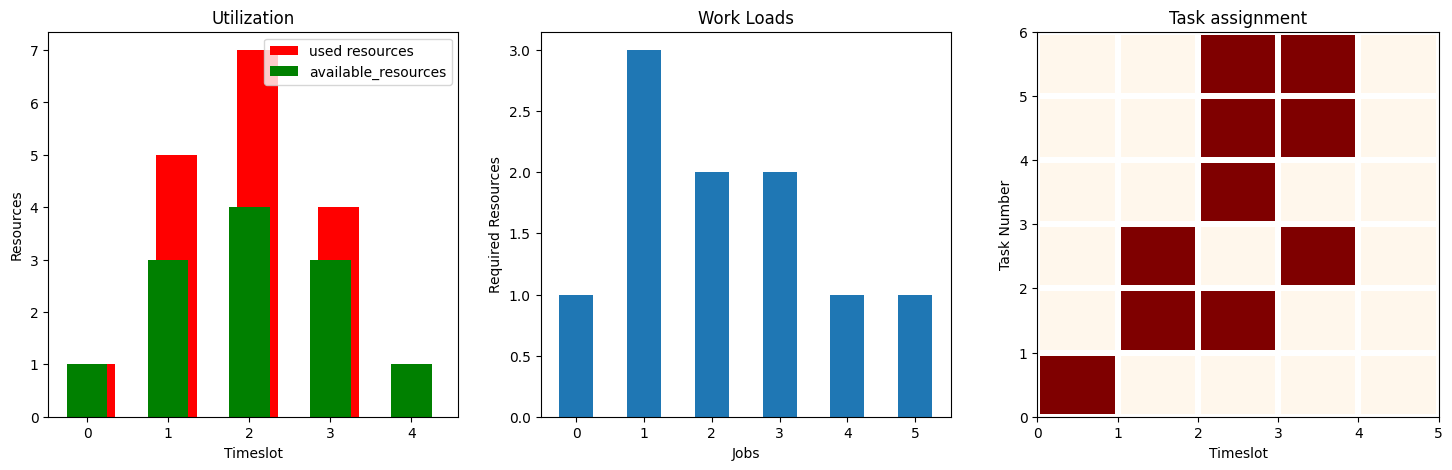

In [31]:
qaoa_solution_large = np.array(
    optimization_result.solution[optimization_result.cost.idxmin()]
).reshape(num_timeslots, len(G.nodes))
plot_workflow(qaoa_solution_large)

## Classical solution for the large problem

In [32]:
from pyomo.opt import SolverFactory

solver = SolverFactory("couenne")
solver.solve(tasks_model_large)

tasks_model_large.display()

Model task_scheduling

  Variables:
    x : Size=30, Index=x_index
        Key    : Lower : Value                  : Upper : Fixed : Stale : Domain
        (0, 0) :     0 :                    1.0 :     1 : False : False : Binary
        (0, 1) :     0 :                    0.0 :     1 : False : False : Binary
        (0, 2) :     0 :                    0.0 :     1 : False : False : Binary
        (0, 3) :     0 :                    0.0 :     1 : False : False : Binary
        (0, 4) :     0 :                    0.0 :     1 : False : False : Binary
        (0, 5) :     0 :                    0.0 :     1 : False : False : Binary
        (1, 0) :     0 :                    0.0 :     1 : False : False : Binary
        (1, 1) :     0 :                    1.0 :     1 : False : False : Binary
        (1, 2) :     0 :                    0.0 :     1 : False : False : Binary
        (1, 3) :     0 :                    0.0 :     1 : False : False : Binary
        (1, 4) :     0 :                  

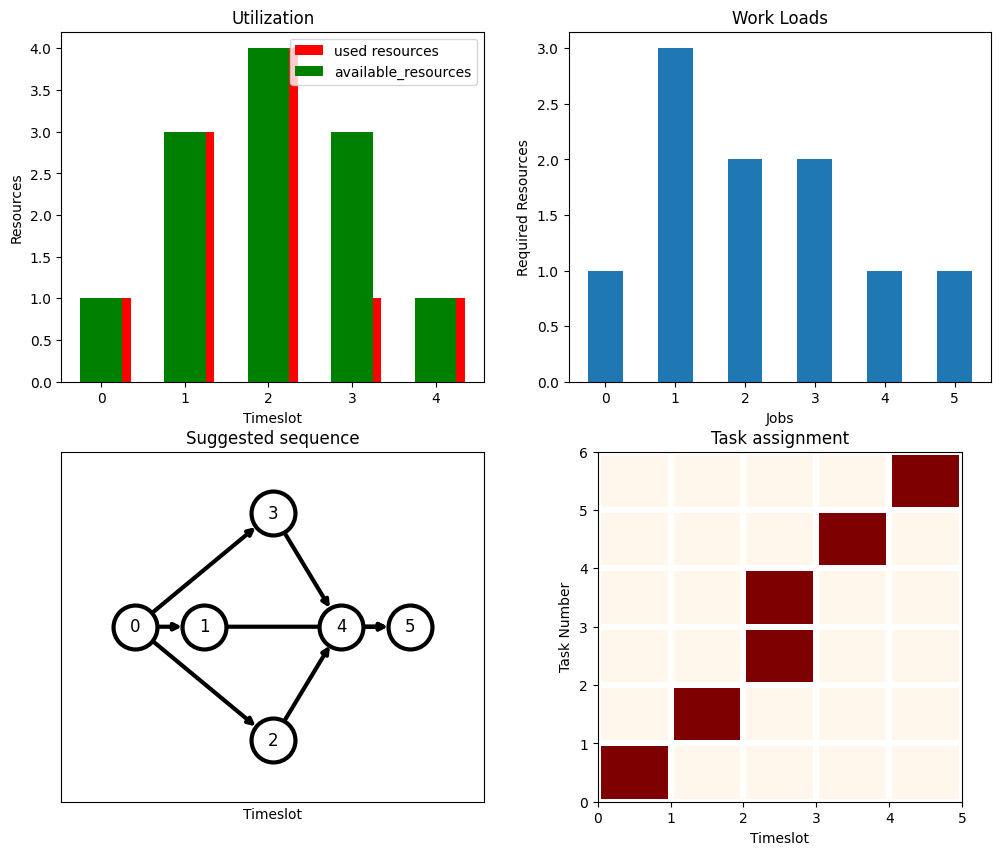

In [33]:
classical_solution = np.array(
    [
        int(pyo.value(tasks_model_large.x[idx]))
        for idx in np.ndindex(num_timeslots, len(G.nodes))
    ]
).reshape(num_timeslots, len(G.nodes))
plot_workflow(classical_solution)

## References

<a id='TaskWorkflow'>[1]</a>: [Pakhomchik et. al. "Solving workflow scheduling problems with QUBO modeling." arXiv preprint arXiv:2205.04844 (2022).](https://arxiv.org/pdf/2205.04844.pdf)
